In [1]:
import os

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

import cmcrameri.cm as cmc
import math

In [2]:
def myround(x, base=1):
    return base * round(x/base)

In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [4]:
def bootstrap(data, n=1000, proportion = 1):
    """Bootstrap resampling of data.

    Args:
        data: 1D array of data to be resampled.
        n: number of resamples to take.

    Returns:
        resampled data.
    """

    rng = np.random.default_rng()

    resampled_data = rng.choice(data, (n, int(len(data)*proportion)), replace = True)

    return resampled_data

In [5]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):

    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    #print(start, end)
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [6]:
def gaussian(x, amp=0.85804736, mean=0.54331667, stddev=0.2471021):
    #gaussian(x, 0.85804736, 0.54331667, 0.2471021)
	return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

In [7]:
def triangle(x, center = 0.55, peak = 1, start = 0.05, end = 1.05):
    x = np.array(x)
    dx = 1/len(x)
    y = np.zeros(len(x))

    left_m = peak/(center-start)
    right_m = peak/(end-center)

    #print(left_m, right_m)

    y[int(start/dx):int(center/dx)] = left_m*x[int(start/dx):int(center/dx)]
    y[int(start/dx):int(center/dx)] = y[int(start/dx):int(center/dx)] - y[int(start/dx)]
    y[int(center/dx):int(end/dx)] = -right_m*x[int(center/dx):int(end/dx)]
    y[int(center/dx):int(end/dx)] = y[int(center/dx):int(end/dx)] + abs(y[int(center/dx)]) + peak
    y[0: int(0.14*len(x))] = 1.13*x[0:int(0.14*len(x))] + 0.03
    #print(y[int(len(x)*((end-center)/(end-start)))])
    # y[:int(len(right_m)] = y[:int(len(right_m)] - min(y[:int(len(x)/2)])
    # y[int(len(x)/2):] = y[int(len(x)/2):] - min(y[int(len(x)/2):])

    return y

In [8]:
def boxcar(x, start=0.2, end=0.2, peak=0.85):
    length = len(x)
    start_index = int(start*len(x))
    end_index = int(end*len(x))
    y = np.zeros(len(x))
    y[start_index:length-end_index] = peak

    return y

In [9]:
def trapezium(x, start = 0.46, end = 0.4, peak = 0.85, start_height = -0.1, end_height = 0.11):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    #print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.linspace(start_height, peak, start_index)
    y[start_index:length-end_index] = peak
    y[length-end_index:] = peak - np.linspace(end_height, peak, end_index) + end_height
    y[0: int(0.14*len(x))] = 1.13*x[0:int(0.14*len(x))] + 0.03
    return y


In [10]:
def sine_boxcar(x, start = 0.55, end = 0.45, peak = 0.85, start_height = 0.05, end_height = 0.2):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    #print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = (np.sin(np.linspace(-math.pi/2, math.pi/2, start_index))+1)*((peak-start_height)/2)+start_height
    y[start_index:length-end_index] = peak
    y[length-end_index:] = ((np.sin(np.linspace(-math.pi/2, math.pi/2, end_index)))[::-1]+1)*((peak-end_height)/2)+end_height
    return y

In [11]:
def comparison_calculation(funct, x):
    proportions_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

    #print(proportion)
    durations = []
    g_root_times = []
    g_relative_root_times = []


    for proportion in proportions_list:

        diff = []
        moments = []


        # Generate x values
        #x = np.linspace(-4, 4, 100)

        # Generate y values
        y = funct(x)

        # Use the generated Gaussian values
        momentrate_opt, time_opt = y, x

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        g_root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        g_root_idx = np.floor(g_root/dx)
        g_root_time = g_root_idx*dx
        g_root_times.append(g_root_time)
        g_relative_root_times.append(g_root_time-start_time)

    g_relative_root_times = np.array(g_relative_root_times)
    return g_relative_root_times/durations

In [12]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

sigloch_results_db = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/sigloch_relative_root_times.csv')
scardec_results_db = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec_relative_root_times.csv')
usgs_results_db = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/usgs_relative_root_times.csv')
isc_results_db = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/isc_relative_root_times.csv')
ye_results_db = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/ye_relative_root_times.csv')

In [13]:
sigloch_results_db.columns = ['event', '10', '20', '30', '40', '50', '60', '70', '80', '90']
scardec_results_db.columns = ['event', '10', '20', '30', '40', '50', '60', '70', '80', '90']
usgs_results_db.columns = ['event', '10', '20', '30', '40', '50', '60', '70', '80', '90']
isc_results_db.columns = ['event', '10', '20', '30', '40', '50', '60', '70', '80', '90']
ye_results_db.columns = ['event', '10', '20', '30', '40', '50', '60', '70', '80', '90']

In [14]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [15]:
combined.columns

Index(['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag'], dtype='object')

In [16]:
combined
combined.columns = ['events', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [17]:
catalog = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_m55_catalog.csv', sep = '|')

In [18]:
cols = catalog.columns
column_names = []
for c in cols:
    column_names.append(c.strip().rstrip().lower())
column_names[0] = 'catalog_id'
catalog.columns = column_names

In [19]:
catalog['year'] = catalog.apply(lambda x: x['time'][:4], axis = 1)
catalog['month'] = catalog.apply(lambda x: x['time'][5:7], axis = 1)
catalog['day'] = catalog.apply(lambda x: x['time'][8:10], axis = 1)
catalog['hour'] = catalog.apply(lambda x: x['time'][11:13], axis = 1)
catalog['minute'] = catalog.apply(lambda x: x['time'][14:16], axis = 1)

catalog['event'] = catalog.apply(lambda x: x['year'] + x['month'] + x['day'] + '_' + x['hour'] + x['minute'], axis = 1)

catalog['int_magnitude'] = catalog.apply(lambda x: myround(x['magnitude']), axis = 1)

In [20]:
catalog.drop(columns = ['contributor', 'contributorid', 'magauthor', 'eventlocationname', 'author', 'catalog', 'time'], inplace = True)

In [21]:
catalog = catalog[['event', 'catalog_id', 'year', 'month', 'day', 'hour', 'minute', 'latitude', 'longitude', 'depth/km', 'magnitude', 'int_magnitude', 'magtype']]

In [22]:
results_db = sigloch_results_db
results_db.sort_values(by = 'event', inplace = True, ignore_index=True)

results_5 = pd.DataFrame(columns = ['event', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

#results_10['event'] = results_db['event']
results_5['event'] = results_db.apply(lambda x: x['event'][:-2], axis = 1)

results_5['0_10'] = results_db['10']
results_5['10_20'] = results_db['20'] - results_db['10']
results_5['20_30'] = results_db['30'] - results_db['20']
results_5['30_40'] = results_db['40'] - results_db['30']
results_5['40_50'] = results_db['50'] - results_db['40']
results_5['50_60'] = results_db['60'] - results_db['50']
results_5['60_70'] = results_db['70'] - results_db['60']
results_5['70_80'] = results_db['80'] - results_db['70']
results_5['80_90'] = results_db['90'] - results_db['80']
results_5['90_100'] = 1 - results_db['90']

results_10_and_catalog = pd.merge(results_5, catalog, on = 'event', how = 'inner')
results_10_and_catalog = results_10_and_catalog[['event', 'catalog_id', 'year', 'month', 'day', 'hour', 'minute', 'latitude', 'longitude', 'depth/km', 'magnitude', 'int_magnitude', 'magtype', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']]

results_10_and_catalog.to_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/sigloch_results_10.csv', index = False)


In [23]:
results_10_and_catalog

,event,catalog_id,year,month,day,hour,minute,latitude,longitude,depth/km,...,0_10,10_20,20_30,30_40,40_50,50_60,60_70,70_80,80_90,90_100
0,19900530_0234,2814540,1990,05,30,02,34,-6.0307,-77.2142,2.5,...,0.258621,0.258621,0.068966,0.034483,0.017241,0.034483,0.017241,0.051724,0.120690,0.137931
1,19910903_0905,223098,1991,09,03,09,05,-17.8562,-116.0124,8.5,...,0.300000,0.100000,0.100000,0.000000,0.100000,0.000000,0.100000,0.100000,0.000000,0.200000
2,19920217_0001,231612,1992,02,17,00,01,79.1748,124.5240,10.0,...,0.307692,0.076923,0.153846,0.000000,0.000000,0.153846,0.000000,0.000000,0.076923,0.230769
3,19920217_0001,231612,1992,02,17,00,01,79.1748,124.5240,10.0,...,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.111111,0.222222
4,19920302_1229,239130,1992,03,02,12,29,52.8835,159.8808,41.7,...,0.275862,0.068966,0.034483,0.034483,0.103448,0.000000,0.103448,0.034483,0.137931,0.206897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,20180415_1930,10728247,2018,04,15,19,30,1.4083,126.8759,34.0,...,0.128205,0.025641,0.051282,0.025641,0.538462,0.102564,0.000000,0.025641,0.051282,0.051282
3065,20180419_2109,10762979,2018,04,19,21,09,-42.7797,42.1877,10.0,...,0.266667,0.133333,0.000000,0.133333,0.000000,0.000000,0.133333,0.000000,0.133333,0.200000
3066,20180419_2109,10762979,2018,04,19,21,09,-42.7797,42.1877,10.0,...,0.266667,0.200000,0.000000,0.000000,0.066667,0.066667,0.133333,0.066667,0.066667,0.133333
3067,20180429_2223,10766369,2018,04,29,22,23,-39.2647,46.1195,10.0,...,0.207547,0.452830,0.094340,0.037736,0.018868,0.037736,0.000000,0.056604,0.037736,0.056604


In [24]:
results_10_and_catalog_filtered = results_10_and_catalog[results_10_and_catalog['magnitude'] <= 7.2].copy()

In [25]:
results_10_and_catalog_filtered.to_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/sigloch_results_10.csv', index = False)


In [26]:
results_5 = results_10_and_catalog

In [27]:
usgs_results_db

,event,10,20,30,40,50,60,70,80,90
0,20120320_1802,0.288136,0.389831,0.457627,0.525424,0.576271,0.593220,0.661017,0.728814,0.796610
1,20200623_1529,0.272727,0.381818,0.436364,0.509091,0.581818,0.636364,0.672727,0.745455,0.836364
2,20161225_1422,0.222222,0.288889,0.355556,0.466667,0.544444,0.600000,0.666667,0.744444,0.822222
3,20190615_2255,0.222222,0.305556,0.388889,0.430556,0.486111,0.569444,0.625000,0.708333,0.819444
4,20110820_1655,0.241935,0.338710,0.419355,0.483871,0.548387,0.596774,0.677419,0.758065,0.838710
...,...,...,...,...,...,...,...,...,...,...
241,20230206_1024,0.146635,0.199824,0.238319,0.272113,0.310314,0.359389,0.433147,0.564796,0.783720
242,20231202_1437,0.240189,0.318336,0.382612,0.455007,0.520298,0.579838,0.641746,0.719553,0.806834
243,19971108_1002,0.127551,0.173469,0.209184,0.244898,0.290816,0.372449,0.489796,0.602041,0.750000
244,20181220_1701,0.139665,0.189944,0.234637,0.284916,0.351955,0.430168,0.575419,0.703911,0.849162


In [28]:
results_5

,event,catalog_id,year,month,day,hour,minute,latitude,longitude,depth/km,...,0_10,10_20,20_30,30_40,40_50,50_60,60_70,70_80,80_90,90_100
0,19900530_0234,2814540,1990,05,30,02,34,-6.0307,-77.2142,2.5,...,0.258621,0.258621,0.068966,0.034483,0.017241,0.034483,0.017241,0.051724,0.120690,0.137931
1,19910903_0905,223098,1991,09,03,09,05,-17.8562,-116.0124,8.5,...,0.300000,0.100000,0.100000,0.000000,0.100000,0.000000,0.100000,0.100000,0.000000,0.200000
2,19920217_0001,231612,1992,02,17,00,01,79.1748,124.5240,10.0,...,0.307692,0.076923,0.153846,0.000000,0.000000,0.153846,0.000000,0.000000,0.076923,0.230769
3,19920217_0001,231612,1992,02,17,00,01,79.1748,124.5240,10.0,...,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.111111,0.222222
4,19920302_1229,239130,1992,03,02,12,29,52.8835,159.8808,41.7,...,0.275862,0.068966,0.034483,0.034483,0.103448,0.000000,0.103448,0.034483,0.137931,0.206897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,20180415_1930,10728247,2018,04,15,19,30,1.4083,126.8759,34.0,...,0.128205,0.025641,0.051282,0.025641,0.538462,0.102564,0.000000,0.025641,0.051282,0.051282
3065,20180419_2109,10762979,2018,04,19,21,09,-42.7797,42.1877,10.0,...,0.266667,0.133333,0.000000,0.133333,0.000000,0.000000,0.133333,0.000000,0.133333,0.200000
3066,20180419_2109,10762979,2018,04,19,21,09,-42.7797,42.1877,10.0,...,0.266667,0.200000,0.000000,0.000000,0.066667,0.066667,0.133333,0.066667,0.066667,0.133333
3067,20180429_2223,10766369,2018,04,29,22,23,-39.2647,46.1195,10.0,...,0.207547,0.452830,0.094340,0.037736,0.018868,0.037736,0.000000,0.056604,0.037736,0.056604


In [29]:
means = results_5[['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']].mean()

In [30]:
# upper = []
# lower = []
# for col_name in ['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']:
#     bs_result = bootstrap(results_10[col_name], n=1000).mean(axis=1)
#     bs_result.sort()
#     lower.append(bs_result[25])
#     upper.append(bs_result[975])


In [31]:
# bootstrapped_df = pd.DataFrame(columns = ['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

# lb_70 = []
# ub_70 = []
# lb_90 = []
# ub_90 = []
# lb_95 = []
# ub_95 = []

# for col_name in ['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100']:
#     bs_result = bootstrap(results_10[col_name], n=1000)
#     bs_result = bs_result.mean(axis=1)
#     bootstrapped_df[col_name] = bs_result
#     bs_result.sort()
#     lb_70.append(bs_result[150])
#     ub_70.append(bs_result[850])
#     lb_90.append(bs_result[50])
#     ub_90.append(bs_result[950])
#     lb_95.append(bs_result[25])
#     ub_95.append(bs_result[975])

In [32]:
results_10_and_catalog

,event,catalog_id,year,month,day,hour,minute,latitude,longitude,depth/km,...,0_10,10_20,20_30,30_40,40_50,50_60,60_70,70_80,80_90,90_100
0,19900530_0234,2814540,1990,05,30,02,34,-6.0307,-77.2142,2.5,...,0.258621,0.258621,0.068966,0.034483,0.017241,0.034483,0.017241,0.051724,0.120690,0.137931
1,19910903_0905,223098,1991,09,03,09,05,-17.8562,-116.0124,8.5,...,0.300000,0.100000,0.100000,0.000000,0.100000,0.000000,0.100000,0.100000,0.000000,0.200000
2,19920217_0001,231612,1992,02,17,00,01,79.1748,124.5240,10.0,...,0.307692,0.076923,0.153846,0.000000,0.000000,0.153846,0.000000,0.000000,0.076923,0.230769
3,19920217_0001,231612,1992,02,17,00,01,79.1748,124.5240,10.0,...,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.111111,0.222222
4,19920302_1229,239130,1992,03,02,12,29,52.8835,159.8808,41.7,...,0.275862,0.068966,0.034483,0.034483,0.103448,0.000000,0.103448,0.034483,0.137931,0.206897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,20180415_1930,10728247,2018,04,15,19,30,1.4083,126.8759,34.0,...,0.128205,0.025641,0.051282,0.025641,0.538462,0.102564,0.000000,0.025641,0.051282,0.051282
3065,20180419_2109,10762979,2018,04,19,21,09,-42.7797,42.1877,10.0,...,0.266667,0.133333,0.000000,0.133333,0.000000,0.000000,0.133333,0.000000,0.133333,0.200000
3066,20180419_2109,10762979,2018,04,19,21,09,-42.7797,42.1877,10.0,...,0.266667,0.200000,0.000000,0.000000,0.066667,0.066667,0.133333,0.066667,0.066667,0.133333
3067,20180429_2223,10766369,2018,04,29,22,23,-39.2647,46.1195,10.0,...,0.207547,0.452830,0.094340,0.037736,0.018868,0.037736,0.000000,0.056604,0.037736,0.056604


0.10545587331167479
0.11225288940357743
0.11599074606831947
0.11580289952849791
0.13329145603596573


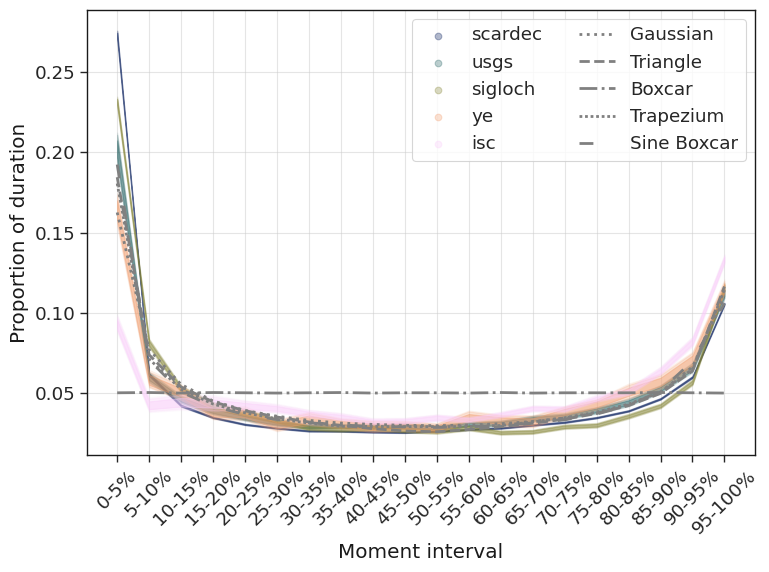

In [34]:
# Offset the x positions for the three datasets
import seaborn as sns

sns.set_theme(style='ticks',
              context='paper', font_scale=1.5,
              rc={'figure.figsize':(8,6)})
            #       'font.size':16})

params = {"axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
          "font.size": 16}
plt.rcParams.update(params)
# plt.rc('legend',fontsize=16)

colors = cmc.batlow(np.linspace(0, 1, 5))
#colors = ['#003f5c', '#bc5090', '#ef5675', 'g', 'c', 'm', 'k', 'y']
styles = ['dotted', 'dashed',  'dashdot', (0, (1, 1)), (0, (5, 10))]


for j, database in enumerate(['scardec', 'usgs', 'sigloch', 'ye', 'isc']):
    results_5 = pd.read_csv(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/{database}_results_5.csv')
    means = results_5[['0_5', '5_10', '10_15', '15_20', '20_25', '25_30', '30_35', '35_40', '40_45', '45_50', '50_55', '55_60', '60_65', '65_70', '70_75', '75_80', '80_85', '85_90', '90_95', '95_100']].mean()
    print(means[-1])
    x_positions = np.arange(len(means))


    plt.scatter([], [], label = database, color = colors[j], alpha = 0.3)

    #bootstrap data to produce error bars
    bootstrapped_df = pd.DataFrame(columns = ['0_5', '5_10', '10_15', '15_20', '20_25', '25_30', '30_35', '35_40', '40_45', '45_50', '50_55', '55_60', '60_65', '65_70', '70_75', '75_80', '80_85', '85_90', '90_95', '95_100'])

    lb_70 = []
    ub_70 = []
    lb_90 = []
    ub_90 = []
    lb_95 = []
    ub_95 = []

    for col_name in ['0_5', '5_10', '10_15', '15_20', '20_25', '25_30', '30_35', '35_40', '40_45', '45_50', '50_55', '55_60', '60_65', '65_70', '70_75', '75_80', '80_85', '85_90', '90_95', '95_100']:
        bs_result = bootstrap(results_5[col_name], n=1000)
        bs_result = np.nanmean(bs_result, axis=1)
        bootstrapped_df[col_name] = bs_result
        bs_result.sort()
        lb_70.append(bs_result[150])
        ub_70.append(bs_result[850])
        lb_90.append(bs_result[50])
        ub_90.append(bs_result[950])
        lb_95.append(bs_result[25])
        ub_95.append(bs_result[975])

    lb_70 = np.array(lb_70)
    ub_70 = np.array(ub_70)
    lb_90 = np.array(lb_90)
    ub_90 = np.array(ub_90)
    lb_95 = np.array(lb_95)
    ub_95 = np.array(ub_95)

    # Error bars
    plt.fill_between(x_positions, lb_70, ub_70, color=colors[j], alpha=0.4)
    plt.fill_between(x_positions, lb_90, ub_90, color=colors[j], alpha=0.2)
    plt.fill_between(x_positions, lb_95, ub_95, color=colors[j], alpha=0.1)


for funct, label in zip([gaussian, triangle, boxcar, trapezium, sine_boxcar], ['Gaussian', 'Triangle', 'Boxcar', 'Trapezium', 'Sine Boxcar']):
    x = np.arange(0, 1, 0.0001)
    relative_root_times = comparison_calculation(funct, x)
    calc_5 = []
    calc_5.append(relative_root_times[0])
    for i in range(1, len(relative_root_times)):
        calc_5.append(relative_root_times[i]-relative_root_times[i-1])
    calc_5.append(1-relative_root_times[-1])
    plt.plot(np.arange(0, 20, 1), calc_5, label = label, color = 'grey', zorder = 1, linestyle=styles.pop(0), linewidth=2)

plt.xticks(x_positions, ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25-30%', '30-35%', '35-40%', '40-45%', '45-50%', '50-55%', '55-60%', '60-65%', '65-70%', '70-75%', '75-80%', '80-85%', '85-90%', '90-95%', '95-100%'], rotation=45)



plt.xlabel('Moment interval')
plt.ylabel('Proportion of duration')
#plt.title('Standard deviation of values')
plt.legend(ncol = 2)#, facecolor = '#002147', edgecolor = 'k', labelcolor = 'k')

plt.tight_layout()
plt.grid(alpha = 0.5)

# plt.title('USGS')
# plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/time_for_10_percent_windows_comparison.png' , dpi = 300, transparent = True)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/integrating_comparing_between_datasets/all_plus_models_5_obs.png', dpi = 300)
plt.show()


0.10545587331167479
0.10545587331167479
0.11225288940357743
0.11225288940357743
0.11599074606831947
0.11599074606831947
0.11580289952849791
0.11580289952849791
0.13329145603596573
0.13329145603596573


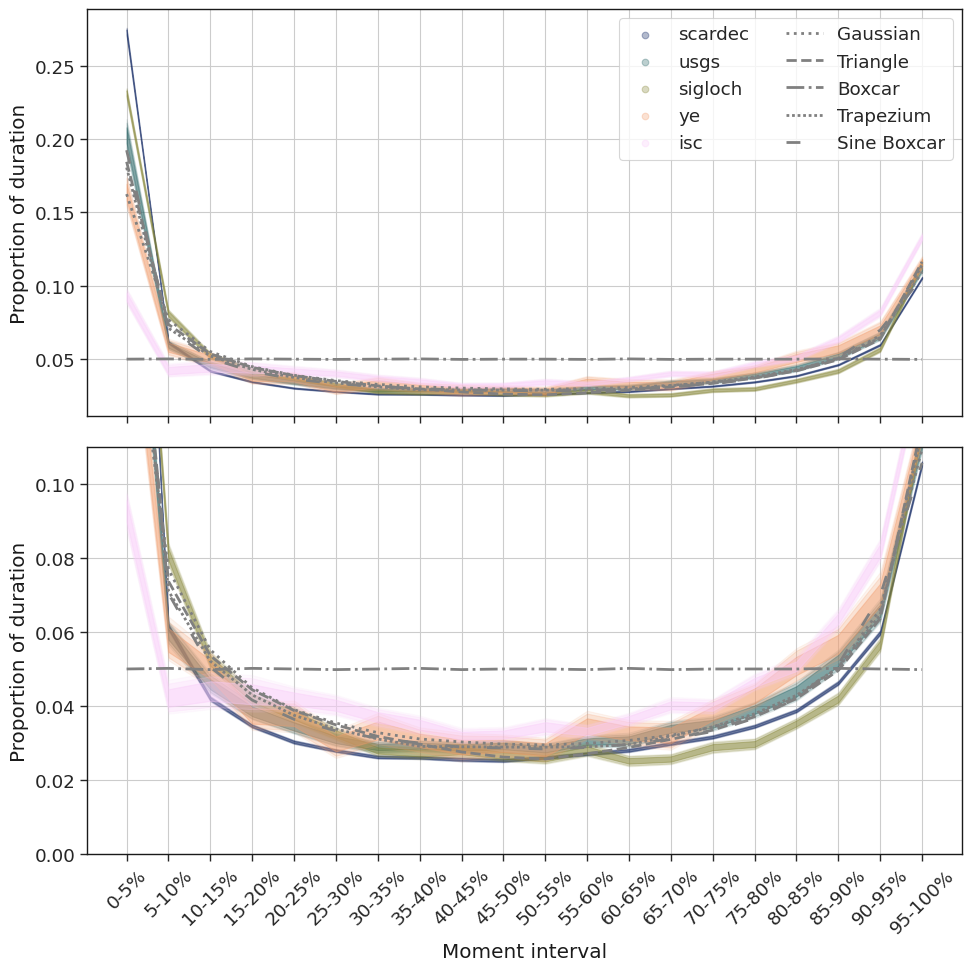

In [35]:
# Offset the x positions for the three datasets
import seaborn as sns

sns.set_theme(style='ticks',
              context='paper', font_scale=1.5,
              rc={'figure.figsize':(8,6)})
            #       'font.size':16})

params = {"axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
          "font.size": 16}
plt.rcParams.update(params)
# plt.rc('legend',fontsize=16)

colors = cmc.batlow(np.linspace(0, 1, 5))
#colors = ['#003f5c', '#bc5090', '#ef5675', 'g', 'c', 'm', 'k', 'y']
styles = ['dotted', 'dashed',  'dashdot', (0, (1, 1)), (0, (5, 10))]

fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

for j, database in enumerate(['scardec', 'usgs', 'sigloch', 'ye', 'isc']):
    results_5 = pd.read_csv(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/{database}_results_5.csv')
    means = results_5[['0_5', '5_10', '10_15', '15_20', '20_25', '25_30', '30_35', '35_40', '40_45', '45_50', '50_55', '55_60', '60_65', '65_70', '70_75', '75_80', '80_85', '85_90', '90_95', '95_100']].mean()

    for ax in axs:
        x_positions = np.arange(len(means))

        print(means[-1])
        x_positions = np.arange(len(means))


        ax.scatter([], [], label = database, color = colors[j], alpha = 0.3)

        bootstrapped_df = pd.DataFrame(columns = ['0_5', '5_10', '10_15', '15_20', '20_25', '25_30', '30_35', '35_40', '40_45', '45_50', '50_55', '55_60', '60_65', '65_70', '70_75', '75_80', '80_85', '85_90', '90_95', '95_100'])

        lb_70 = []
        ub_70 = []
        lb_90 = []
        ub_90 = []
        lb_95 = []
        ub_95 = []

        for col_name in ['0_5', '5_10', '10_15', '15_20', '20_25', '25_30', '30_35', '35_40', '40_45', '45_50', '50_55', '55_60', '60_65', '65_70', '70_75', '75_80', '80_85', '85_90', '90_95', '95_100']:
            bs_result = bootstrap(results_5[col_name], n=1000)
            bs_result = np.nanmean(bs_result, axis=1)
            bootstrapped_df[col_name] = bs_result
            bs_result.sort()
            lb_70.append(bs_result[150])
            ub_70.append(bs_result[850])
            lb_90.append(bs_result[50])
            ub_90.append(bs_result[950])
            lb_95.append(bs_result[25])
            ub_95.append(bs_result[975])


        lb_70 = np.array(lb_70)
        ub_70 = np.array(ub_70)
        lb_90 = np.array(lb_90)
        ub_90 = np.array(ub_90)
        lb_95 = np.array(lb_95)
        ub_95 = np.array(ub_95)

        # Error bars
        ax.fill_between(x_positions, lb_70, ub_70, color=colors[j], alpha=0.4)
        ax.fill_between(x_positions, lb_90, ub_90, color=colors[j], alpha=0.2)
        ax.fill_between(x_positions, lb_95, ub_95, color=colors[j], alpha=0.1)

for ax in axs:
    colors = cmc.batlow(np.linspace(0, 1, 5))
    #colors = ['#003f5c', '#bc5090', '#ef5675', 'g', 'c', 'm', 'k', 'y']
    styles = ['dotted', 'dashed',  'dashdot', (0, (1, 1)), (0, (5, 10))]
    for funct, label in zip([gaussian, triangle, boxcar, trapezium, sine_boxcar], ['Gaussian', 'Triangle', 'Boxcar', 'Trapezium', 'Sine Boxcar']):
        x = np.arange(0, 1, 0.0001)
        relative_root_times = comparison_calculation(funct, x)
        calc_10 = []
        calc_10.append(relative_root_times[0])
        for i in range(1, len(relative_root_times)):
            calc_10.append(relative_root_times[i]-relative_root_times[i-1])
        calc_10.append(1-relative_root_times[-1])
        ax.plot(np.arange(0, 20, 1), calc_10, label = label, color = 'grey', zorder = 1, linestyle=styles.pop(0), linewidth=2)

    ax.set_xticks(x_positions, ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25-30%', '30-35%', '35-40%', '40-45%', '45-50%', '50-55%', '55-60%', '60-65%', '65-70%', '70-75%', '75-80%', '80-85%', '85-90%', '90-95%', '95-100%'], rotation=45)


    ax.grid()
    ax.set_ylabel('Proportion of duration')
    #plt.title('Standard deviation of values')
axs[1].set_xlabel('Moment interval')
axs[0].legend(ncol = 2)#, facecolor = '#002147', edgecolor = 'k', labelcolor = 'k')

axs[1].set_ylim(0, 0.11)
plt.tight_layout()
# plt.title('USGS')
# plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/time_for_10_percent_windows_comparison.png' , dpi = 300, transparent = True)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/integrating_comparing_between_datasets/panels_all_plus_models_5_obs.png', dpi = 300)
plt.show()


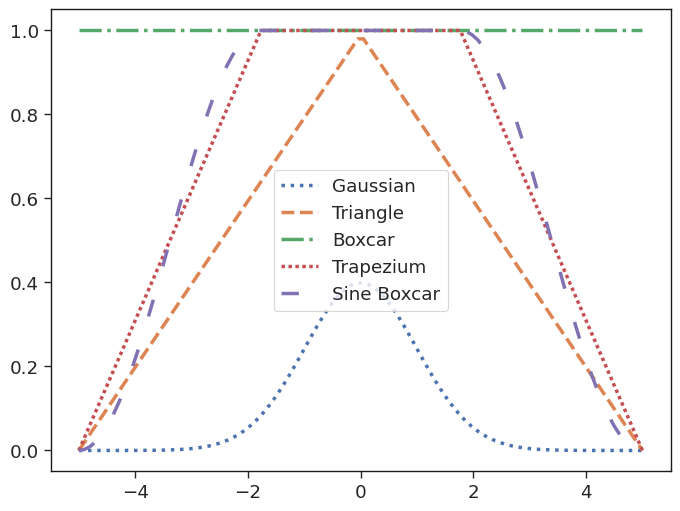

In [123]:
x = np.linspace(-5, 5, 100)
styles = ['dotted', 'dashed',  'dashdot', (0, (1, 1)), (0, (5, 10))]


plt.plot(x, gaussian(x), label = 'Gaussian', linestyle=styles.pop(0), linewidth = 2.5)
plt.plot(x, triangle(x), label = 'Triangle', linestyle=styles.pop(0), linewidth = 2.5)
plt.plot(x, boxcar(x), label = 'Boxcar', linestyle=styles.pop(0), linewidth = 2.5)
plt.plot(x, trapezium(x), label = 'Trapezium', linestyle=styles.pop(0), linewidth = 2.5)
plt.plot(x, sine_boxcar(x), label = 'Sine Boxcar', linestyle=styles.pop(0), linewidth = 2.5)

plt.legend()

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/integrating_comparing_between_datasets/models.png', dpi = 300)